In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from catboost import CatBoostClassifier, Pool

In [121]:
root_dir = os.path.dirname(os.getcwd())
display(root_dir)
data_dir = os.path.join(root_dir, 'data')
display(data_dir)
train_path = os.path.join(data_dir, 'train.xlsx')
display(train_path)

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack'

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data'

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data\\train.xlsx'

In [122]:
df = pd.read_excel(train_path)

In [123]:
display(df.head())

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4
3,3,20230918-7491-223512699,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,NaT,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3
4,4,20230529-6634-200121971,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,NaT,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1


In [124]:
target = df['Дата отмены'].notna().astype(int)
display(target)

0        1
1        0
2        0
3        0
4        0
        ..
26169    0
26170    0
26171    0
26172    1
26173    0
Name: Дата отмены, Length: 26174, dtype: int32

In [125]:
df = df.drop(["Unnamed: 0","№ брони", "Дата отмены","Статус брони"], axis=1)
display(df)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,2
26170,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Номер «Студия»,3,4
26171,1,55600.0,13900,Банк. карта: Банк Россия (банк. карта),2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Номер «Стандарт»,2,2
26172,1,6300.0,0,Гарантия банковской картой,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Номер «Стандарт»,2,3


### Train-test split learning

In [126]:
def tt_split():
    target = df['Дата отмены'].notna().astype(int)
    display(target)
    
    
    train_df = df.sample(frac=0.8, random_state=42)
    test_df = df.drop(train_df.index)
    display(train_df.shape, test_df.shape)
    
    
    train_target = target[train_df.index]
    test_target = target.drop(train_df.index)
    display(train_target,train_target.shape)
    display(test_target,test_target.shape)
    
    
    train_pool = Pool(train_df, train_target, cat_features=categorical_features)
    test_pool = Pool(test_df, test_target, cat_features=categorical_features)

In [127]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)
display(train_df.shape, test_df.shape)

(20939, 12)

(5235, 12)

In [128]:
categorical_features = ["Способ оплаты", "Источник","Категория номера"]

In [129]:
train_target = target[train_df.index]
test_target = target.drop(train_df.index)
display(train_target,train_target.shape)
display(test_target,test_target.shape)


5405     0
20995    0
15439    0
19500    0
17112    0
        ..
17888    1
1806     0
3871     0
3791     1
24555    0
Name: Дата отмены, Length: 20939, dtype: int32

(20939,)

9        0
11       0
13       0
16       1
24       1
        ..
26155    0
26156    0
26163    0
26170    0
26172    1
Name: Дата отмены, Length: 5235, dtype: int32

(5235,)

In [130]:
train_pool = Pool(train_df, train_target, cat_features=categorical_features)
test_pool = Pool(test_df, test_target, cat_features=categorical_features)

### Model init with params {epochs = 100 , depth = 6} - will test

In [131]:
model = CatBoostClassifier()

In [132]:
model.fit(train_pool,plot=True,eval_set = test_pool, use_best_model = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067172
0:	learn: 0.6318153	test: 0.6322180	best: 0.6322180 (0)	total: 55.6ms	remaining: 55.5s
1:	learn: 0.5787184	test: 0.5809032	best: 0.5809032 (1)	total: 108ms	remaining: 53.9s
2:	learn: 0.5374644	test: 0.5401995	best: 0.5401995 (2)	total: 156ms	remaining: 52s
3:	learn: 0.5031975	test: 0.5070154	best: 0.5070154 (3)	total: 203ms	remaining: 50.6s
4:	learn: 0.4744083	test: 0.4793862	best: 0.4793862 (4)	total: 255ms	remaining: 50.7s
5:	learn: 0.4502870	test: 0.4559825	best: 0.4559825 (5)	total: 322ms	remaining: 53.3s
6:	learn: 0.4309951	test: 0.4373422	best: 0.4373422 (6)	total: 393ms	remaining: 55.7s
7:	learn: 0.4156489	test: 0.4227954	best: 0.4227954 (7)	total: 426ms	remaining: 52.8s
8:	learn: 0.3993618	test: 0.4076353	best: 0.4076353 (8)	total: 475ms	remaining: 52.3s
9:	learn: 0.3859120	test: 0.3951032	best: 0.3951032 (9)	total: 524ms	remaining: 51.9s
10:	learn: 0.3761379	test: 0.3859422	best: 0.3859422 (10)	total: 573ms	remaining: 51.6s
11:	learn: 0.3677344	te

In [133]:
predictions = model.predict(test_pool)
display(predictions,predictions.shape)
display(test_target)
accuracy = (predictions == test_target).mean()
print(f'Accuracy: {accuracy}')
from sklearn.metrics import roc_auc_score
score = roc_auc_score(predictions,test_target)
display(score)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

(5235,)

9        0
11       0
13       0
16       1
24       1
        ..
26155    0
26156    0
26163    0
26170    0
26172    1
Name: Дата отмены, Length: 5235, dtype: int32

Accuracy: 0.8905444126074499


0.9144337719840564

In [134]:
tdf_path = os.path.join(data_dir, 'test.xlsx')
display(tdf_path)
tdf = pd.read_excel(tdf_path)
display(tdf.head())

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data\\test.xlsx'

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,0,20231129-16563-238946689,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,20221219-7491-174959103,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,2,20221211-6634-172724329,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,3,20230821-6634-212247350,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,4,20230326-6634-189784563,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1


In [136]:
tdf = tdf.drop(["Unnamed: 0","№ брони"], axis=1)
display(tdf)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11213,1,50200.0,50200,Банк. карта [Кешбэк. МИР]: Эквайринг TravelLin...,2022-03-27 21:30:38,2022-05-07 15:00:00,2,2022-05-09 12:00:00,Официальный сайт,Номер «Студия»,4,2
11214,1,190100.0,43500,Система быстрых платежей: Эквайринг ComfortBoo...,2023-11-11 17:51:55,2024-02-16 15:00:00,5,2024-02-21 12:00:00,Официальный сайт,Коттедж с 2 спальнями,4,1
11215,1,42300.0,42300,Банк. карта: Банк Россия (банк. карта),2022-02-09 02:23:14,2022-02-09 15:00:00,1,2022-02-10 12:00:00,Официальный сайт,Коттедж с 3 спальнями,5,1
11216,1,27900.0,27900,Банк. карта: Банк Россия (банк. карта),2023-01-21 09:10:17,2023-01-28 15:00:00,1,2023-01-29 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1


In [137]:
res=model.predict(tdf)
display(res)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [138]:
hist, bin_edges = np.histogram(res, bins=2)
print(f"Гистограмма: {hist}")
print(f"Границы интервалов: {bin_edges}")

Гистограмма: [10032  1186]
Границы интервалов: [0.  0.5 1. ]


In [139]:
catboost_res_dir = os.path.join(root_dir, 'catboost_res')

In [140]:
ans = model.predict_proba(tdf)[:, 1]
    
ans = pd.DataFrame(ans, columns = ['apply_promo'])
ans.to_csv('cat80.csv', index=False,header= False)

# Learn on all data

In [21]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=True)

In [22]:
categorical_features = ["Способ оплаты", "Источник","Категория номера"]

In [23]:
df = pd.read_excel(train_path)
target = df['Дата отмены'].notna().astype(int)
df = df.drop(["Unnamed: 0","№ брони", "Дата отмены","Статус брони"], axis=1)
display(df.head(),df.shape)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1


(26174, 12)

In [24]:
tdf_path = os.path.join(data_dir, 'test.xlsx')
display(tdf_path)
tdf = pd.read_excel(tdf_path)
display(tdf.head())
tdf = tdf.drop(["Unnamed: 0","№ брони"], axis=1)
display(tdf.head())

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data\\test.xlsx'

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,0,20231129-16563-238946689,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,20221219-7491-174959103,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,2,20221211-6634-172724329,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,3,20230821-6634-212247350,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,4,20230326-6634-189784563,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1


,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1


In [25]:
train_df = df 
test_df = tdf

In [26]:
train_pool = Pool(train_df, target, cat_features=categorical_features)

In [27]:
model.fit(train_pool)

0:	learn: 0.6115333	total: 44.1ms	remaining: 22s
1:	learn: 0.5398979	total: 110ms	remaining: 27.4s
2:	learn: 0.4890657	total: 167ms	remaining: 27.7s
3:	learn: 0.4477813	total: 219ms	remaining: 27.2s
4:	learn: 0.4170576	total: 272ms	remaining: 27s
5:	learn: 0.3963912	total: 325ms	remaining: 26.8s
6:	learn: 0.3800712	total: 403ms	remaining: 28.4s
7:	learn: 0.3669606	total: 475ms	remaining: 29.2s
8:	learn: 0.3571257	total: 519ms	remaining: 28.3s
9:	learn: 0.3482528	total: 563ms	remaining: 27.6s
10:	learn: 0.3412013	total: 603ms	remaining: 26.8s
11:	learn: 0.3354012	total: 644ms	remaining: 26.2s
12:	learn: 0.3293279	total: 685ms	remaining: 25.7s
13:	learn: 0.3255539	total: 729ms	remaining: 25.3s
14:	learn: 0.3224932	total: 779ms	remaining: 25.2s
15:	learn: 0.3200993	total: 829ms	remaining: 25.1s
16:	learn: 0.3174780	total: 875ms	remaining: 24.9s
17:	learn: 0.3156590	total: 926ms	remaining: 24.8s
18:	learn: 0.3142657	total: 968ms	remaining: 24.5s
19:	learn: 0.3130569	total: 1.02s	remaining:

In [28]:
res=model.predict(tdf)
display(res)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [29]:
ans = model.predict_proba(tdf)[:, 1]
    
ans = pd.DataFrame(ans, columns = ['apply_promo'])
ans.to_csv('cat100.csv', index=False,header= False)

## Another preproc
### Hotel to [0,1]

In [181]:
model = CatBoostClassifier(eval_metric='AUC')

In [182]:
categorical_features = ["Источник","weekday", 'Категория номера', "Способ оплаты", "month"]

In [183]:
df = pd.read_excel(train_path)
target = df['Дата отмены'].notna().astype(int)
df = df.drop(["Unnamed: 0","№ брони", "Дата отмены","Статус брони"], axis=1)
display(df.head(),df.shape)

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,2,1
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,2,4
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,1,3
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,4,1


(26174, 12)

In [184]:
df['Гостиница']=(df['Гостиница'] >= 3).astype(int)
# types = ['Стандарт', 'Люкс', 'Апартаменты', 'Студия', 'Коттедж']
# for t in types:
#     df[t] = df['Категория номера'].str.contains(t).astype(int)
df['month'] = df['Дата бронирования'].apply(lambda x : x.strftime('%m'))
df['weekday'] = df['Дата бронирования'].apply(lambda x : x.strftime('%a'))
df['delta_day'] = (df['Заезд'] - df['Дата бронирования']).dt.days
# df['Способ оплаты'] = df['Способ оплаты'].str.startswith('Внешняя система оплаты').astype(int)
display(df.columns)

Index(['Номеров', 'Стоимость', 'Внесена предоплата', 'Способ оплаты',
       'Дата бронирования', 'Заезд', 'Ночей', 'Выезд', 'Источник',
       'Категория номера', 'Гостей', 'Гостиница', 'month', 'weekday',
       'delta_day'],
      dtype='object')

In [185]:
tdf_path = os.path.join(data_dir, 'test.xlsx')
display(tdf_path)
tdf = pd.read_excel(tdf_path)
display(tdf.head())
tdf = tdf.drop(["Unnamed: 0","№ брони"], axis=1)
display(tdf.head())

'C:\\Users\\32233\\OneDrive\\Documents\\HSE\\AI\\projects\\PSB_hack\\data\\test.xlsx'

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,0,20231129-16563-238946689,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,20221219-7491-174959103,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,2,20221211-6634-172724329,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,3,20230821-6634-212247350,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,4,20230326-6634-189784563,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1


,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1


In [186]:
tdf['Гостиница']=(tdf['Гостиница'] >= 3).astype(int)
# types = ['Стандарт', 'Люкс', 'Апартаменты', 'Студия', 'Коттедж']
# for t in types:
#     tdf[t] = tdf['Категория номера'].str.contains(t).astype(int)
tdf['month'] = tdf['Дата бронирования'].apply(lambda x : x.strftime('%m'))
tdf['weekday'] = tdf['Дата бронирования'].apply(lambda x : x.strftime('%a'))
tdf['delta_day'] = (tdf['Заезд'] - tdf['Дата бронирования']).dt.days
# tdf['Способ оплаты'] = tdf['Способ оплаты'].str.startswith('Внешняя система оплаты').astype(int)
display(tdf.head())

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,month,weekday,delta_day
0,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,1,11,Tue,1
1,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,1,12,Mon,6
2,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,0,11,Fri,15
3,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,0,07,Tue,33
4,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,0,03,Thu,3


In [187]:
from sklearn.preprocessing import MinMaxScaler

# Предположим, у вас есть DataFrame 'df'

# Создаем объект MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем столбцы 'Стоимость', 'Внесена предоплата', 'delta_day', 'Гостей'
df[['Стоимость', 'Внесена предоплата', 'delta_day', 'Гостей']] = scaler.fit_transform(
    df[['Стоимость', 'Внесена предоплата', 'delta_day', 'Гостей']]
)

In [188]:
display(df.head())

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,month,weekday,delta_day
0,1,0.026053,0.000000,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,0.066667,0,04,Thu,0.028070
1,1,0.025141,0.021215,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,0.066667,0,06,Sat,0.084211
2,1,0.026155,0.022070,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,0.066667,1,11,Mon,0.070175
3,1,0.010644,0.000000,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,0.000000,1,09,Fri,0.035088
4,1,0.029085,0.049085,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,0.200000,0,05,Sat,0.031579


In [189]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)
display(train_df.shape, test_df.shape)


train_target = target[train_df.index]
test_target = target.drop(train_df.index)
display(train_target,train_target.shape)
display(test_target,test_target.shape)


train_pool = Pool(train_df, train_target, cat_features=categorical_features)
test_pool = Pool(test_df, test_target, cat_features=categorical_features)

(20939, 15)

(5235, 15)

5405     0
20995    0
15439    0
19500    0
17112    0
        ..
17888    1
1806     0
3871     0
3791     1
24555    0
Name: Дата отмены, Length: 20939, dtype: int32

(20939,)

9        0
11       0
13       0
16       1
24       1
        ..
26155    0
26156    0
26163    0
26170    0
26172    1
Name: Дата отмены, Length: 5235, dtype: int32

(5235,)

In [190]:
model.fit(train_pool,eval_set = test_pool, use_best_model = True,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067172
0:	test: 0.8188119	best: 0.8188119 (0)	total: 58.1ms	remaining: 58s
1:	test: 0.8275531	best: 0.8275531 (1)	total: 119ms	remaining: 59.2s
2:	test: 0.8270575	best: 0.8275531 (1)	total: 175ms	remaining: 58.3s
3:	test: 0.8279667	best: 0.8279667 (3)	total: 241ms	remaining: 1m
4:	test: 0.8291734	best: 0.8291734 (4)	total: 349ms	remaining: 1m 9s
5:	test: 0.8298232	best: 0.8298232 (5)	total: 418ms	remaining: 1m 9s
6:	test: 0.8296212	best: 0.8298232 (5)	total: 483ms	remaining: 1m 8s
7:	test: 0.8283337	best: 0.8298232 (5)	total: 541ms	remaining: 1m 7s
8:	test: 0.8291176	best: 0.8298232 (5)	total: 592ms	remaining: 1m 5s
9:	test: 0.8282950	best: 0.8298232 (5)	total: 648ms	remaining: 1m 4s
10:	test: 0.8270842	best: 0.8298232 (5)	total: 690ms	remaining: 1m 2s
11:	test: 0.8283910	best: 0.8298232 (5)	total: 771ms	remaining: 1m 3s
12:	test: 0.8284988	best: 0.8298232 (5)	total: 827ms	remaining: 1m 2s
13:	test: 0.8286259	best: 0.8298232 (5)	total: 880ms	remaining: 1m 1s
14:	

In [191]:
ans = model.predict_proba(tdf)[:, 1]
    
ans = pd.DataFrame(ans, columns = ['apply_promo'])
ans.to_csv('lot_of_onehot.csv', index=False,header= False)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [192]:
res_df = pd.DataFrame(res)
res_df.to_csv(os.path.join(catboost_res_dir,"pels.csv"),index = False, header=None)

In [159]:
display(df.head())

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,month,weekday,delta_day
0,1,0.026053,0.000000,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Номер «Стандарт»,0.066667,0,04,Thu,0.028070
1,1,0.025141,0.021215,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Номер «Стандарт»,0.066667,0,06,Sat,0.084211
2,1,0.026155,0.022070,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Номер «Студия»,0.066667,1,11,Mon,0.070175
3,1,0.010644,0.000000,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Номер «Стандарт»,0.000000,1,09,Fri,0.035088
4,1,0.029085,0.049085,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Номер «Люкс»,0.200000,0,05,Sat,0.031579


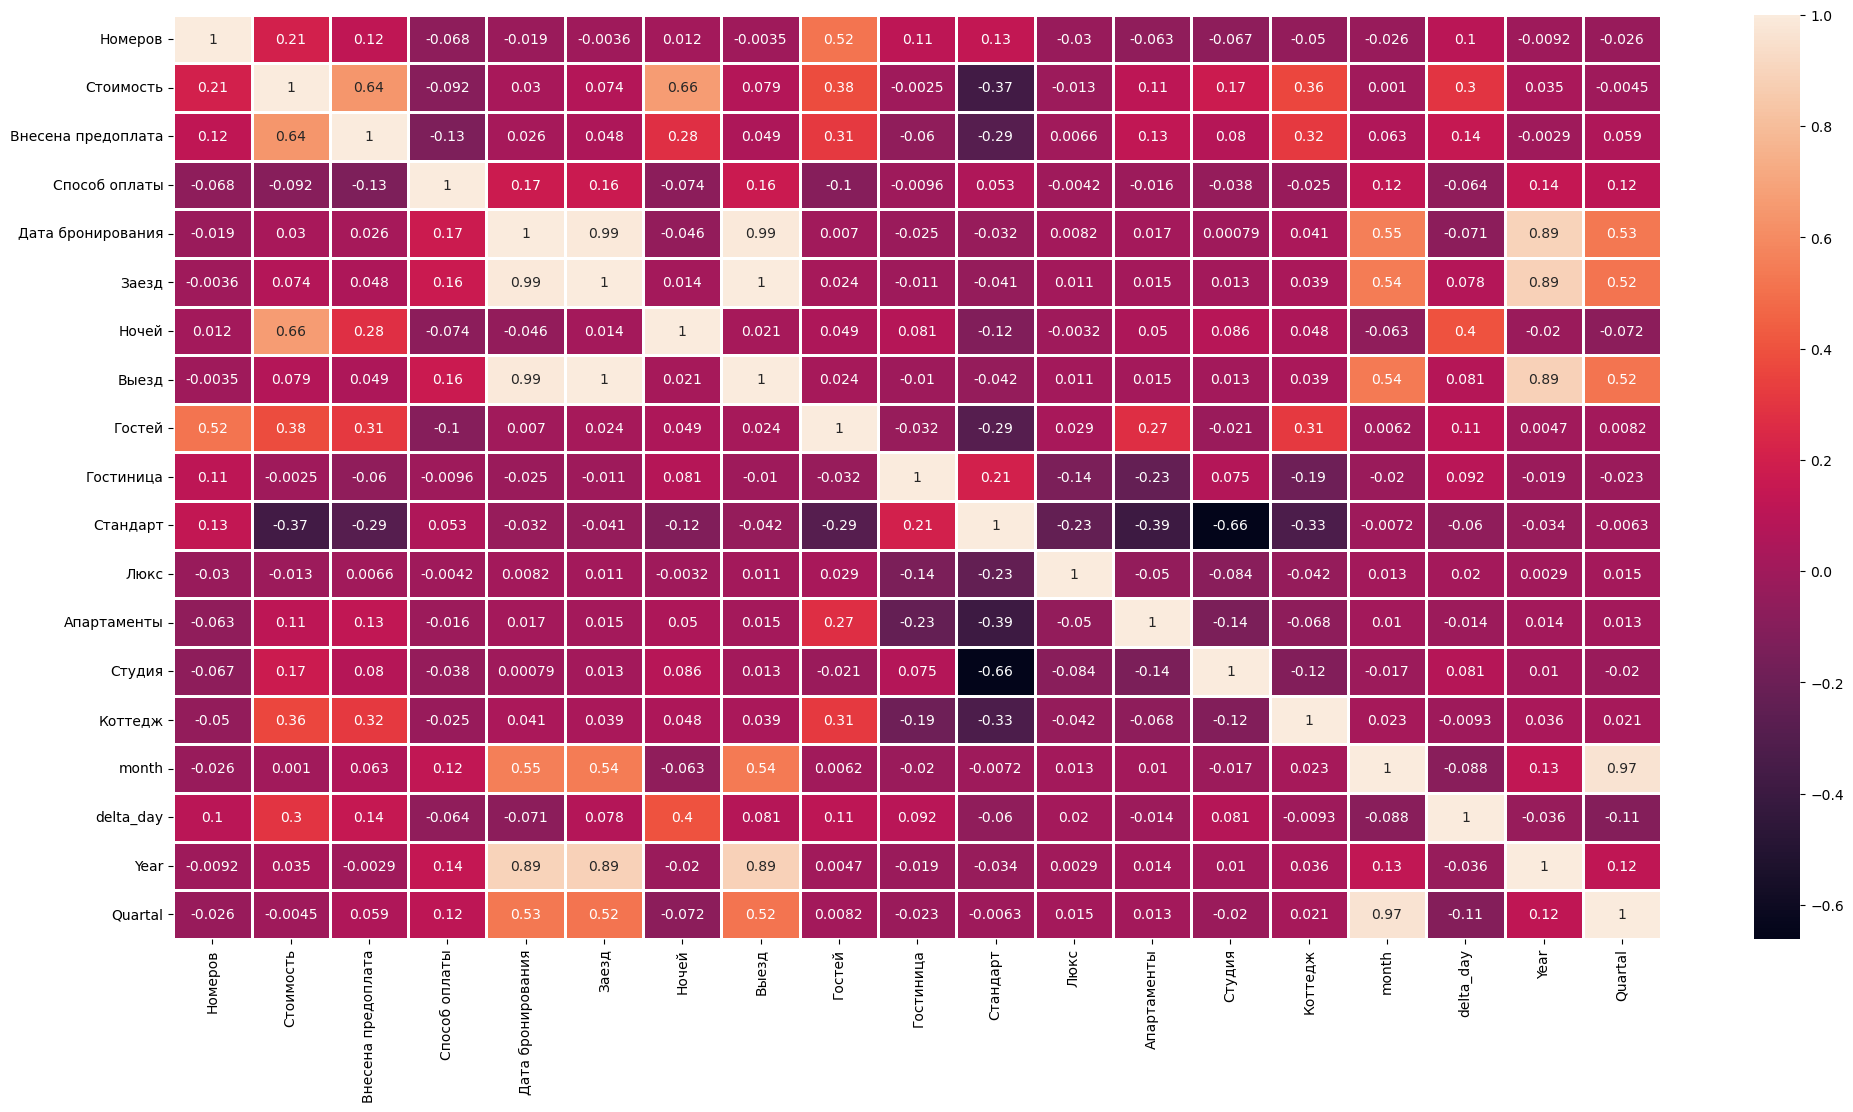

In [65]:
import seaborn as sns
plt.figure(figsize = (24, 12))
df = df.drop(["Источник", "Категория номера", "weekday"], axis=1)
corr = df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

# Data split